In [7]:
from glob import glob
import math

import trimesh
import numpy as np
from scipy.interpolate import griddata
import scipy.ndimage
import scipy.spatial as spatial
from scipy.spatial.distance import cdist
from skimage.feature import peak_local_max

In [2]:
def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2) #range
    #ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0]) #azimuth
    return ptsnew

In [3]:
#steps

#0 calculate centroid and recentre hail at centroid
#?? align to dmax
#1 convert vertices into spherical coordiantes
#2 interpolate onto regular grid
#3 plot

In [26]:
neighborhood_size = 7

In [73]:
#stl_ffn = '/home/meso/data/yalboroo_collection/hailstone09.stl'
stl_ffn = '/home/meso/data/brisbane_collection/hailstone_11.stl'
# load mesh
mymesh = trimesh.load_mesh(stl_ffn)
# volumetric center of mass which we can set as the origin for our mesh
mymesh.vertices -= mymesh.center_mass
# convert to spherical
ptsnew = appendSpherical_np(mymesh.vertices)
mymesh_azi = np.rad2deg(ptsnew[:,5])
mymesh_elv = np.rad2deg(ptsnew[:,4])
mymesh_rng = ptsnew[:,3]

# interpolate
grid_azi, grid_elv = np.meshgrid(np.arange(-180,180,1), np.arange(-90,90,1)) #azimuth, elevation
data = griddata((mymesh_azi, mymesh_elv), mymesh_rng, (grid_azi, grid_elv), method='linear')

median_dist = np.nanmedian(data)

# find local minimum and maximum
nan_mask = np.isnan(data)
data[nan_mask]=0
max_coords = peak_local_max(data, min_distance=neighborhood_size, threshold_rel=0.65, exclude_border=2)
data[nan_mask]=-200
min_coords = peak_local_max(-data, min_distance=neighborhood_size)
data[nan_mask]=np.nan



# use nearest neighbour to find matching vertices of local minimums
kdtree_input_array = np.stack([np.rad2deg(ptsnew[:,5]), np.rad2deg(ptsnew[:,4])], axis=1)
kdtree_obj = spatial.KDTree(kdtree_input_array)

# find triangles which are in the minimum verticies
triangle_idx_array = []
for item in min_coords:
    pt_azi = grid_azi[item[0],item[1]]
    pt_elv = grid_elv[item[0],item[1]]
    minimum_vertices_idx = kdtree_obj.query([pt_azi, pt_elv])[1]
    new_loc = np.where(mymesh.faces == minimum_vertices_idx)
    triangle_idx_array = np.concatenate([triangle_idx_array, new_loc[0]]).astype(np.int32)

#build subset
minmesh = mymesh.submesh([triangle_idx_array])[0]
    
# fit bounding box to local minimums
obb_extends = minmesh.bounding_box_oriented.primitive.extents
minmesh_dmin = obb_extends[0]
minmesh_dint = obb_extends[1]
minmesh_dmax = obb_extends[2]

#calculate oblate elipsoid volume
min_mesh_volume = 4/3 * math.pi * (minmesh_dmax/2) * (minmesh_dint/2) * (minmesh_dmin/2)
#calculate fraction of total volume
total_volume = mymesh.volume
print(mymesh.bounding_box_oriented.primitive.extents)
print(obb_extends)
print(1-(min_mesh_volume/total_volume))

print(np.nanmedian(data))

[69.00754853 72.84339129 80.85391329]
[60.64432496 61.50876654 63.55800214]
0.3475804806243711
33.638869687280746


number of lobes: 52


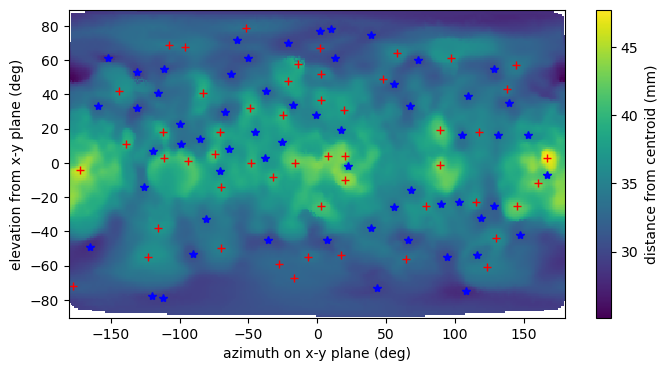

In [74]:
from matplotlib import pyplot as plt
plt.figure(figsize=[8,4])
plt.pcolor(grid_azi, grid_elv, data)
for item in max_coords:
    plt.plot(grid_azi[item[0],item[1]], grid_elv[item[0],item[1]], 'r+')
for item in min_coords:
    plt.plot(grid_azi[item[0],item[1]], grid_elv[item[0],item[1]], 'b*')    
plt.colorbar(label='distance from centroid (mm)')
plt.xlabel('azimuth on x-y plane (deg)')
plt.ylabel('elevation from x-y plane (deg)')
print(f'number of lobes: {len(max_coords)}')

In [75]:
# unmerge so viewer doesn't smooth
mymesh.unmerge_vertices()
# make mesh white- ish
mymesh.visual.face_colors = [255,255,255,255]
mymesh.visual.face_colors[triangle_idx_array] = [255, 0, 0, 255]

scene = trimesh.Scene(mymesh)
scene.show()